# CMA/ES - Hierarchical - Bays09 - 5try: EM fits MSE scaled, more params

EM fits scaled, optimizing Threshold and Sparsity too

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [7]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [29]:
# both output layers
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-704374df-3b02-495e-aaa0-fa6002e70af4.npy').item()

# # 2nd layer output only.
# %cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_4try_emfitscaled_Mratiosigmaxsigmabaselinelapserate_repetitions3_100118/
# results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-745e3a89-520c-487a-8f78-cadd89492430.npy').item()


/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018


In [30]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [31]:
parameter_names_sorted

['M',
 'lapse_rate',
 'ratio_hierarchical',
 'sigma_baseline',
 'sigmax',
 'sparsity',
 'threshold']

In [32]:
metric = 'dist_emfit_scaled'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])
df_all_fits.loc[:, 'M'] = df_all_fits['M'].astype(int)

In [33]:
# Fix M and ratio_conj
ratio_hierarchical, M_lower, M_higher = utils.fix_ratiohierarchical(
    df_all_fits['M'], df_all_fits['ratio_hierarchical'])
df_all_fits.loc[:, 'ratio_hierarchical'] = ratio_hierarchical
df_all_fits.loc[:, 'M_lower'] = M_lower
df_all_fits.loc[:, 'M_higher'] = M_higher

In [34]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 200

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

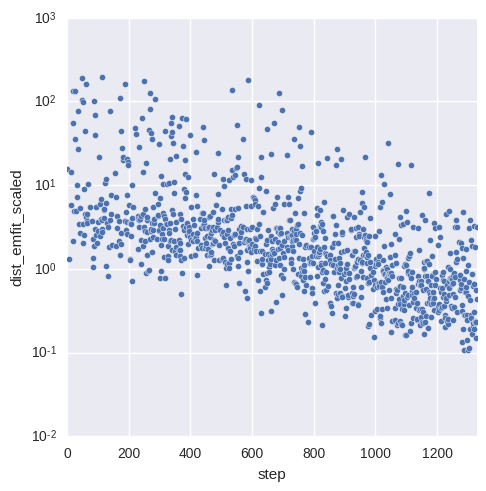

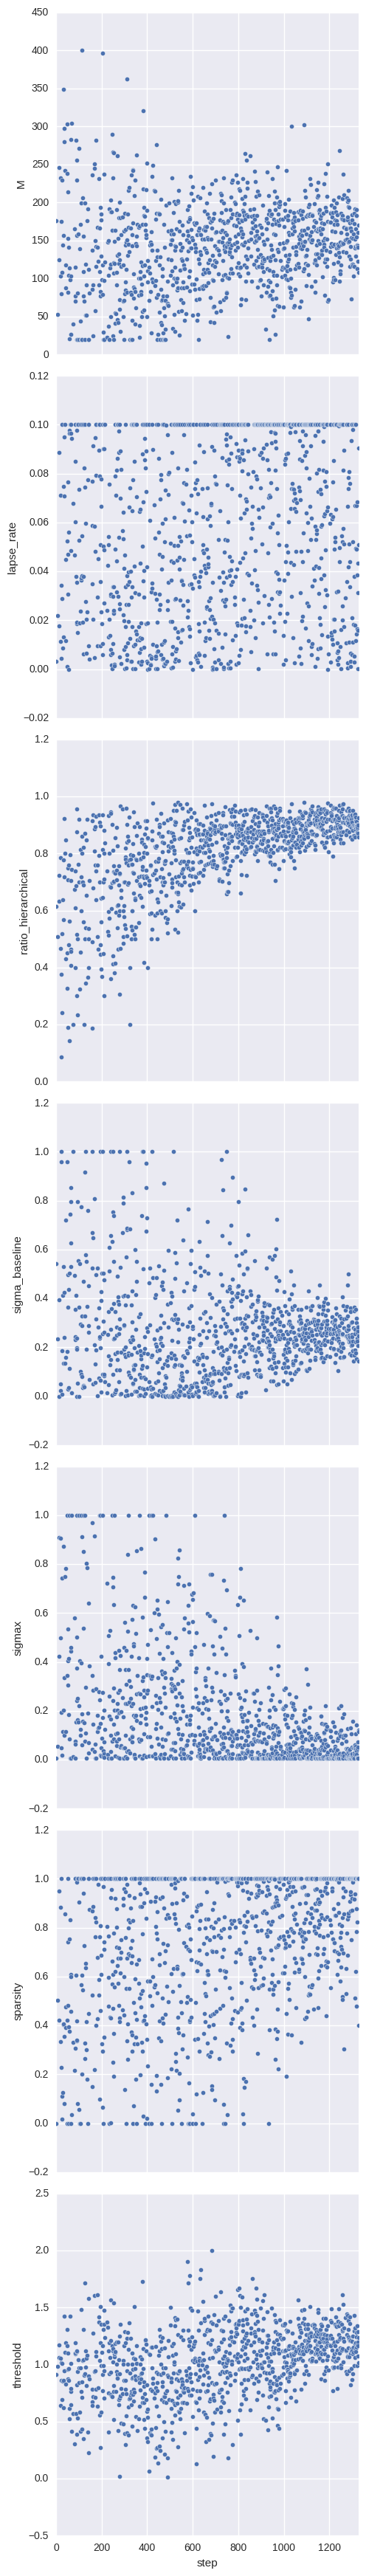

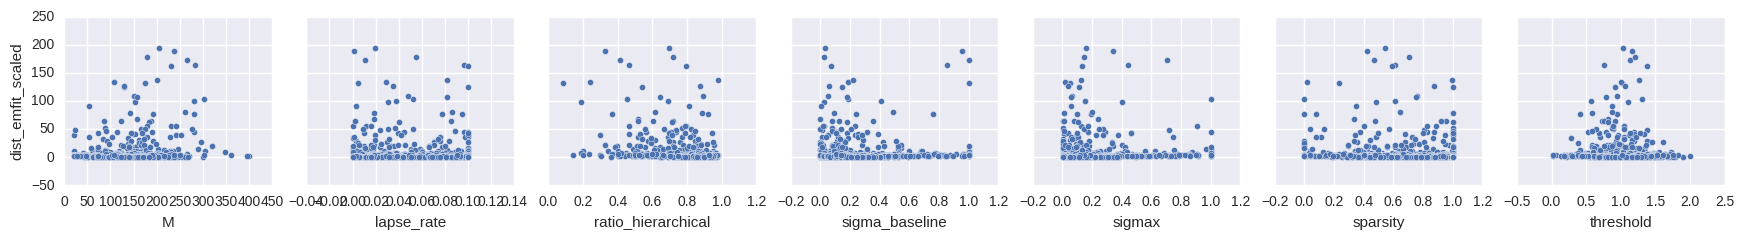

In [35]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )
g.set(yscale = 'log')


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



In [36]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] > 1000]
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.array(df_cmaes_traj['dist_nll92'])
# result_to_color = np.log(result_to_color)

# parameters = ['M', 'ratio_hierarchical', 'sigma_baseline']
parameters = ['lapse_rate', 'M', 'sigma_baseline']

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj[parameters[0]],
        y = df_cmaes_traj[parameters[1]],
        z = df_cmaes_traj[parameters[2]],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title=parameters[0],
        ),
        yaxis=go.YAxis(
            title=parameters[1],
        ),
        zaxis=go.ZAxis(
            title=parameters[2],
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [16]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(1).median().to_dict()
df_bestparams = df_best_fits.sort_values(by=metric).iloc[0].to_dict()

df_bestparams

{'M': 178.0,
 'M_higher': 164.0,
 'M_lower': 14.0,
 'dist_emfit_scaled': 0.15559848175834584,
 'lapse_rate': 0.1,
 'ratio_hierarchical': 0.9213483146067416,
 'sigma_baseline': 0.25237871804434703,
 'sigmax': 0.034309181955866415,
 'sparsity': 0.6135023720640804,
 'step': 995.0,
 'threshold': 1.3482331794061622}

In [17]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             type_layer_one='feature',
                             output_both_layers=None,
                             normalise_weights=1,
                             ratio_hierarchical=0.5,
                             normalise_gain=None,
                             threshold=1.0,                  
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='hierarchical',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=1000, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

Arguments: ['-f', '/run/user/5201/jupyter/kernel-e07b57a3-1923-4dcd-9f9a-06d9864aa672.json']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'code_type': 'hierarchical', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 1.3482331794061622, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'M_lower': 14.0, 'normalise_gain': True, 'job_name': '', 'experiment_data_dir': '../../experimental_data/', 'normalise_we

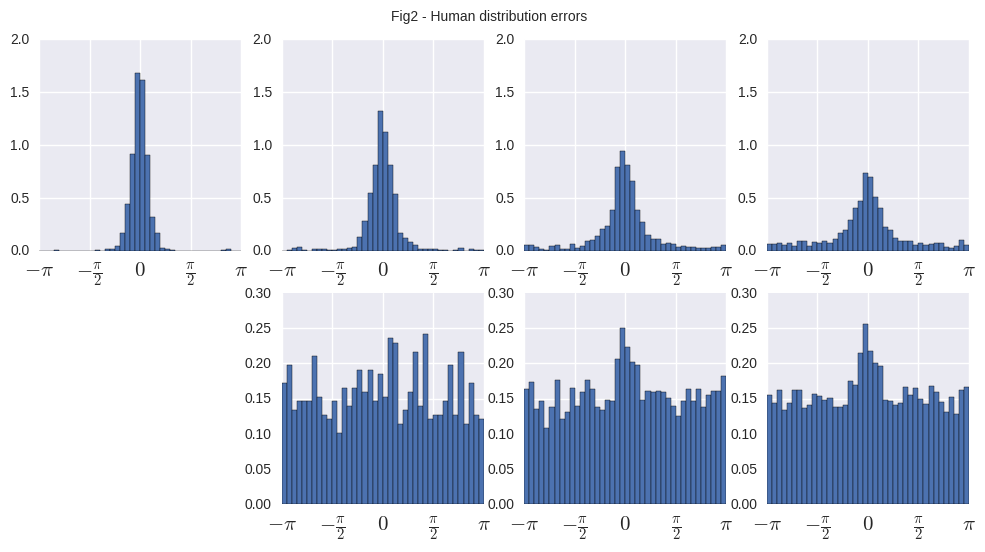

In [18]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

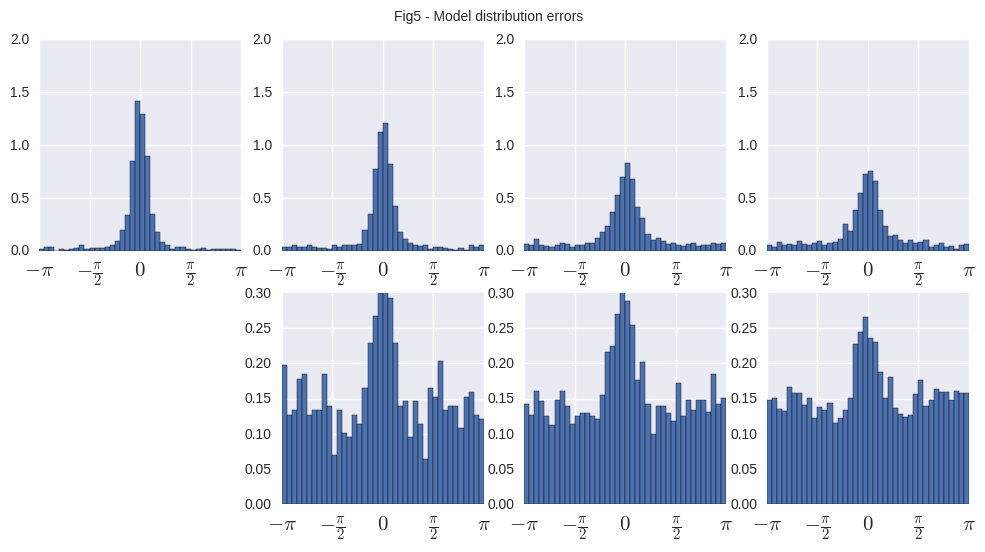

In [19]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

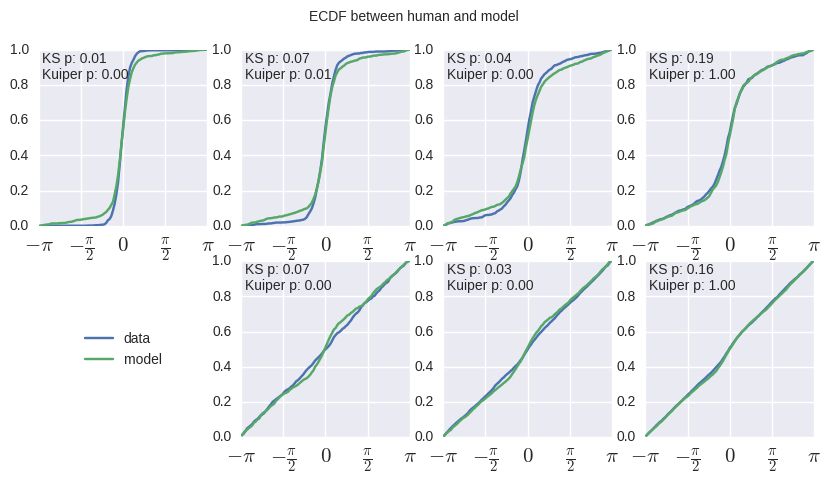

In [20]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((10, 5))

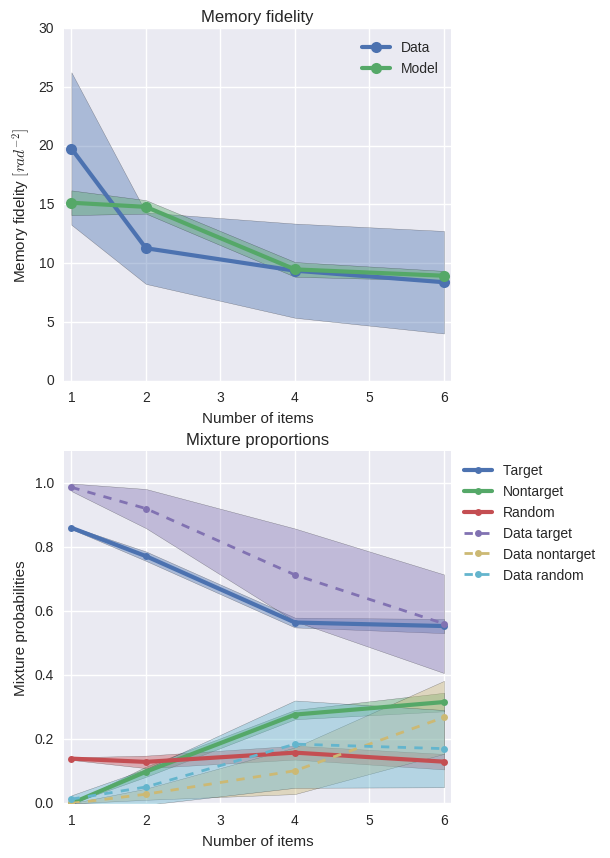

In [21]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

# Discussion: This is actually worst than LL Median

Hierarchical Bays09 is a bit weird to fit.

I will use LL Median instead.


In [1]:
# # Store figures
# dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
#                 label='thesis_hier_bays09_emfitscaled', calling_function='')
# dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

In [2]:
# axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_human_{label}_{unique_id}.pdf"))
# axesFig5[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_model_{label}_{unique_id}.pdf"))
# axes[0, 0].figure.savefig(dataio.create_formatted_filename("ecdf_model_{label}_{unique_id}.pdf"))
# axesFig6Fig13[0].figure.savefig(dataio.create_formatted_filename("emfits_model_{label}_{unique_id}.pdf"))